# Fichaexercicios 2

Exercise  1  |  data  in  f2ex1  |  Calculate  the  Normalized  Difference  Vegetation  Index  using  the 
formula 
$𝑁𝐷𝑉𝐼 = \frac{NIR− RED}{NIR + RED}$


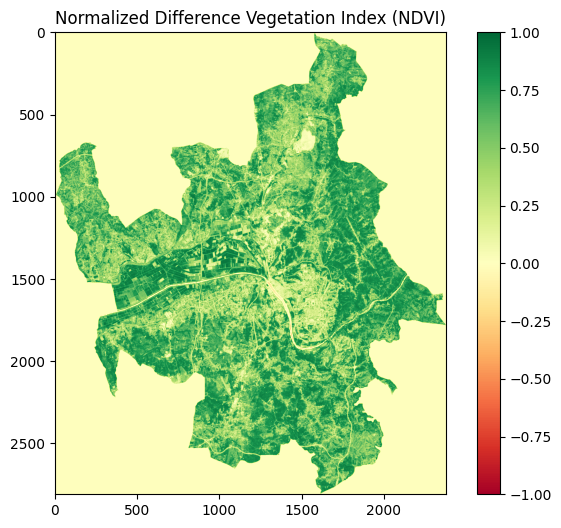

In [2]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

red = 'Maps_and_GISWEB/fichaexercicios2/f2ex1/red_band.tif'
nir = 'Maps_and_GISWEB/fichaexercicios2/f2ex1/nir_band.tif'
out = 'Maps_and_GISWEB/fichaexercicios2/f2ex1/result.tif'

# Read the data from the input rasters
nir_ds = gdal.Open(nir, gdal.GA_ReadOnly)
red_ds = gdal.Open(red, gdal.GA_ReadOnly)

nir_band = nir_ds.GetRasterBand(1)
red_band = red_ds.GetRasterBand(1)

nir_data = nir_band.ReadAsArray().astype(np.float32)
red_data = red_band.ReadAsArray().astype(np.float32)

# Calculate the NDVI
ndvi_data = (nir_data - red_data) / (nir_data + red_data)

# Plot the NDVI image
plt.figure(figsize=(8, 6))
plt.imshow(ndvi_data, cmap='RdYlGn', vmin=-1.0, vmax=1.0)
plt.colorbar()
plt.title('Normalized Difference Vegetation Index (NDVI)')
plt.show()

nir_ds = None
red_ds = None


Exercise 2 | data in f2ex2 | Generate a Digital Elevation Model (DEM) considering the contour lines in the file curvas_nivel.shp. The “ELEVATION” column provides the altitude of each line. In this  procedure,  the  file  lmt.shp  indicates  the  geographic  extent  of  the  final  DEM;  the  file 
lmt_1000m.shp should be used in the DEM creation.

In [3]:
from osgeo import gdal, ogr

contour_lines_ds = ogr.Open('Maps_and_GISWEB/fichaexercicios2/f2ex2/curvas_nivel.shp')
contour_layer = contour_lines_ds.GetLayer()

lmt_ds = ogr.Open('Maps_and_GISWEB/fichaexercicios2/f2ex2/lmt_1000m.shp')
lmt_layer = lmt_ds.GetLayer()

lmt_feature = lmt_layer.GetNextFeature()
lmt_geometry = lmt_feature.GetGeometryRef()
lmt_extent = lmt_geometry.GetEnvelope()

x_res = 10
y_res = 10

width = int((lmt_extent[1] - lmt_extent[0]) / x_res)
height = int((lmt_extent[3] - lmt_extent[2]) / y_res)

output = './Maps_and_GISWEB/fichaexercicios2/results/DEM.tif'
target_ds = gdal.GetDriverByName('GTiff').Create(output, width, height, 1, gdal.GDT_Float32)

target_ds.SetGeoTransform((lmt_extent[0], x_res, 0, lmt_extent[3], 0, -y_res))

target_ds.SetProjection(contour_layer.GetSpatialRef().ExportToWkt())

gdal.RasterizeLayer(target_ds, [1], contour_layer, options=["ATTRIBUTE=ELEVATION"])

contour_lines_ds = None
lmt_ds = None
target_ds = None


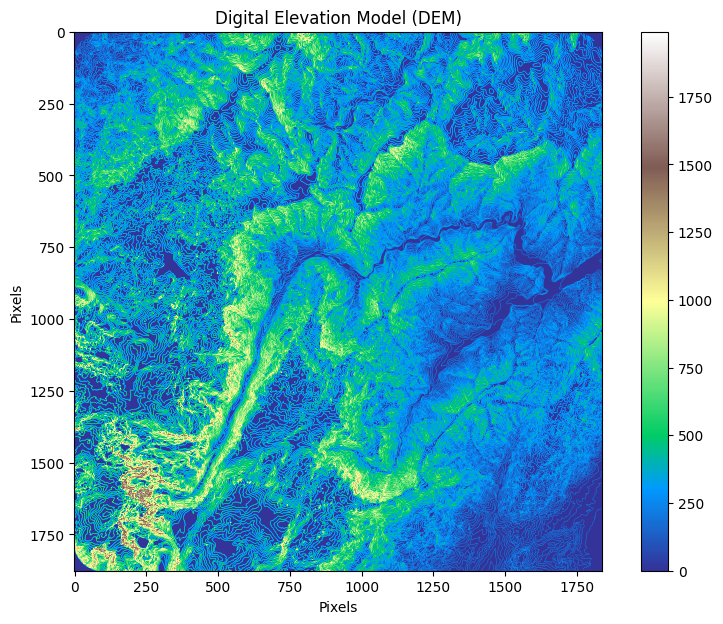

In [4]:
dem_dataset = gdal.Open('./Maps_and_GISWEB/fichaexercicios2/results/DEM.tif')
dem_band = dem_dataset.GetRasterBand(1)

dem_data = dem_band.ReadAsArray()

plt.figure(figsize=(10, 7))
plt.imshow(dem_data, cmap='terrain')
plt.colorbar()
plt.title('Digital Elevation Model (DEM)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

dem_dataset = None

Exercise 3 | data in f2ex3 | Using the file mdt.tif as DEM, produce slope and aspect maps.

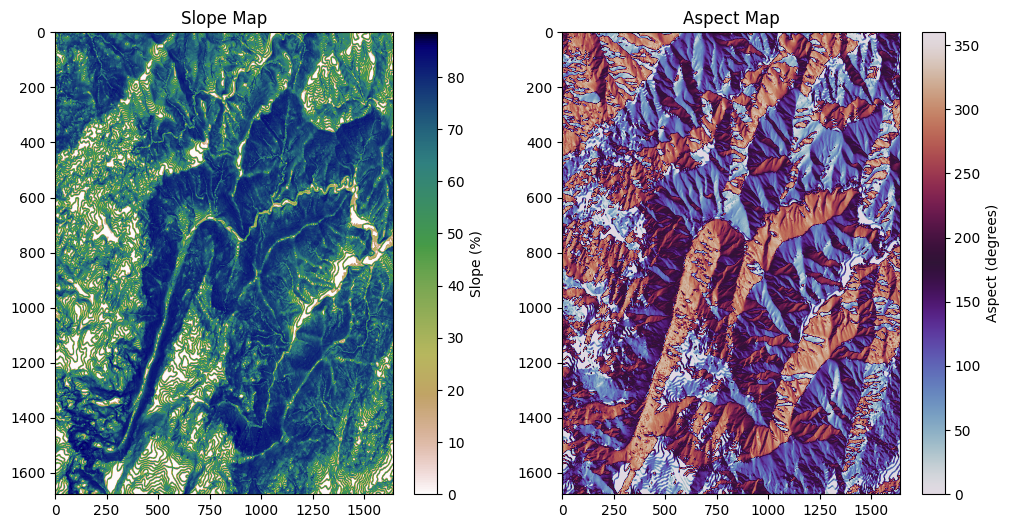

In [22]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

dem_file_path = 'Maps_and_GISWEB/fichaexercicios2/f2ex3/mdt.tif'

ds = gdal.Open(dem_file_path)

band = ds.GetRasterBand(1)
dem_data = band.ReadAsArray()

x, y = np.gradient(dem_data)
slope_rad = np.arctan(np.sqrt(x*x + y*y))
slope_deg = np.degrees(slope_rad)
aspect = np.arctan2(-x, y)
aspect_deg = np.degrees(aspect)
aspect_deg = (aspect_deg + 360) % 360 

# Display the slope and aspect maps
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(slope_deg, cmap='gist_earth_r', aspect='auto')
plt.title('Slope Map')
plt.colorbar(label='Slope (%)')

plt.subplot(1, 2, 2)
plt.imshow(aspect_deg, cmap='twilight', aspect='auto')
plt.title('Aspect Map')
plt.colorbar(label='Aspect (degrees)')

plt.show()

Exercise  4  |  data  in  f2ex4  |  Reclassify  the  exposicao.tif  raster  so  that  the  values  have  the 
following meanings: 
1 – Flat; 2 – North; 3 – Northeast; 4 – East; 5 – Southeast; 6 – South; 7 – Southwest; 8 – 
West; 9 – Northwest

/tmp/ipykernel_3824/3784577246.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('terrain', len(rules))


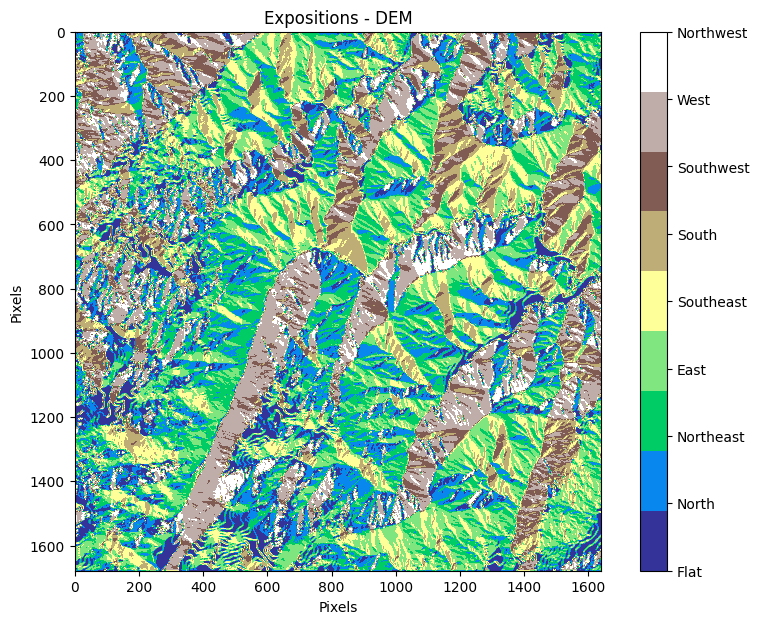

In [29]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# Define the reclassification rules and labels
rules = {
    1: [0],
    2: [45],
    3: [90],
    4: [135],
    5: [180],
    6: [225],
    7: [270],
    8: [315],
    9: [360]
}

labels = {
    1: 'Flat',
    2: 'North',
    3: 'Northeast',
    4: 'East',
    5: 'Southeast',
    6: 'South',
    7: 'Southwest',
    8: 'West',
    9: 'Northwest'
}

# Function for reclassification
def reclassify(data, rules):
    result = np.zeros_like(data)
    for key, values in rules.items():
        for value in values:
            result[(data >= value - 22.5) & (data < value + 22.5)] = key
    return result

file_path = 'Maps_and_GISWEB/fichaexercicios2/f2ex5/exposicao.tif'
ds = gdal.Open(file_path, gdal.GA_ReadOnly)

band = ds.GetRasterBand(1)
data = band.ReadAsArray().astype(np.float32)

reclassified_data = reclassify(data, rules)

cmap = plt.cm.get_cmap('terrain', len(rules))

plt.figure(figsize=(10, 7))
im = plt.imshow(reclassified_data, cmap=cmap, vmin=1, vmax=len(rules))

tick_values = range(1, len(rules) + 1)
cbar = plt.colorbar(im, ticks=tick_values)
cbar.ax.set_yticklabels([labels[i] for i in tick_values])

plt.title('Expositions - DEM')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

dem_dataset = None

Exercise 5 | data in f2ex5 | Generate a raster file with the geographic distribution of areas with 
an altitude greater than 800 meters and a southern exposure. For this purpose, consider the 
DEM mdt.tif and the exposicao.tif raster.

In [30]:
import rasterio
import numpy as np

with rasterio.open('Maps_and_GISWEB/fichaexercicios2/f2ex5/mdt.tif') as src_mdt, rasterio.open('Maps_and_GISWEB/fichaexercicios2/f2ex5/exposicao.tif') as src_exposicao:
    mdt = src_mdt.read(1)
    exposicao = src_exposicao.read(1)

    # Apply conditions for altitude and southern exposure
    condition_altitude = mdt > 800
    condition_exposure = (exposicao > 202.5) & (exposicao < 247.5) 

    # Combine the conditions
    final_condition = np.logical_and(condition_altitude, condition_exposure)

    # # Create a new raster with the combined conditions
    profile = src_mdt.profile  # Use the profile from mdt as a template
    profile.update(count=1) 
    with rasterio.open('./Maps_and_GISWEB/fichaexercicios2/results/final_map.tif', 'w', **profile) as dst:
        dst.write(final_condition.astype(rasterio.uint8), 1)


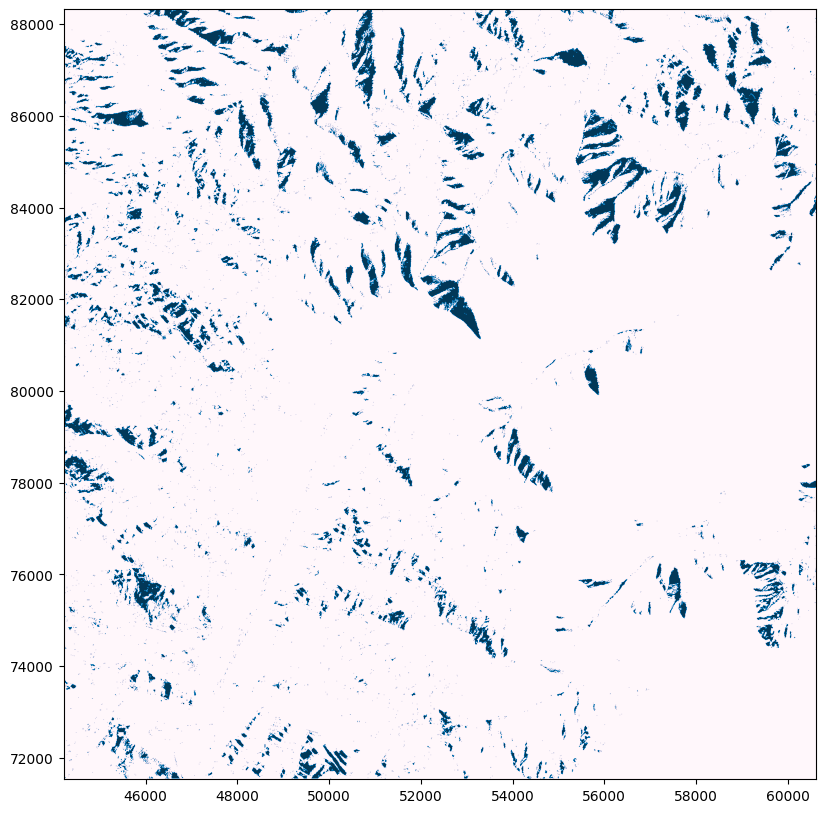

In [38]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

with rasterio.open('./Maps_and_GISWEB/fichaexercicios2/results/final_map.tif') as src:
    plt.figure(figsize=(10, 10))
    show(src, cmap='PuBu')
    plt.show()

Exercise  6  |  data  in  f2ex6  |  Create  a  raster  file  with  the  average  slope  of  each  zone  in  the 
zones.tif file. Here, a zone is any set of contiguous pixels. Consider the file with slopes, named 
declives.tif.

In [32]:
import rasterio
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

zones_path = 'Maps_and_GISWEB/fichaexercicios2/f2ex6/zones.tif'
declives_path = 'Maps_and_GISWEB/fichaexercicios2/f2ex6/declives.tif'
output_path = './Maps_and_GISWEB/fichaexercicios2/results/average_values_zones.tif'

with rasterio.open(declives_path) as src:
    declives = src.read(1)
    profile = src.profile

with rasterio.open(zones_path) as src:
    zones = src.read(1)


def group_pixels_into_zones(zones):
    labeled_array, _ = ndimage.label(zones)
    return labeled_array

labeled_zones = group_pixels_into_zones(zones)

unique_zones = np.unique(labeled_zones)

average_values = []
for i in range(1, labeled_zones.max() + 1):
    mask = labeled_zones == i
    values = declives[mask]
    average_value = np.mean(values)
    average_values.append(average_value)

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(np.array(labeled_zones), 1)

### ... ???

Exercise  7  |  data  in  f2ex7  |  For  each  “Freguesia”  in  Coimbra  (freg_cmb.shp),  provide  the 
average distance (in kilometers) to the nearest school (cmb_escolas.shp). 

In [9]:
import geopandas as gpd
from shapely.ops import nearest_points
from statistics import mean

freguesias = gpd.read_file('Maps_and_GISWEB/fichaexercicios2/f2ex7/freg_cmb.shp')
escolas = gpd.read_file('Maps_and_GISWEB/fichaexercicios2/f2ex7/cmb_escolas.shp')

def calculate_mean_distance_to_schools(unit, schools):
    distances = []
    for _, unit_row in unit.iterrows():
        unit_geometry = unit_row['geometry']
        distances_to_schools = []
        for _, school_row in schools.iterrows():
            school_geometry = school_row['geometry']
            nearest_geoms = nearest_points(unit_geometry, school_geometry)
            distance_in_meters = nearest_geoms[0].distance(nearest_geoms[1])
            distance_in_km = distance_in_meters / 1000
            distances_to_schools.append(distance_in_km)
        distances.append(mean(distances_to_schools))
    return distances

mean_distances = calculate_mean_distance_to_schools(freguesias, escolas)

freguesias['mean_distance_to_schools_km'] = mean_distances

freguesias[['Freguesia', 'mean_distance_to_schools_km']]

,Freguesia,mean_distance_to_schools_km
0,União das freguesias de Souselas e Botão,7.560807
1,Cernache,7.459470
2,Almalaguês,7.738322
3,União das freguesias de Assafarge e Antanhol,4.653569
4,Ceira,6.095818
5,"União das freguesias de Taveiro, Ameal e Arzila",6.140030
6,"União das freguesias de Taveiro, Ameal e Arzila",6.125660
7,União das freguesias de Santa Clara e Castelo ...,3.135108
8,Santo António dos Olivais,3.090068
9,Torres do Mondego,5.427526


Exercise  8  |  data  in  f2ex8  |  Using  slopes  (declives.tif),  slope  exposure  (exposicao.tif),  and 
distance to watercourses (water.shp), produce a raster with the following characteristics.

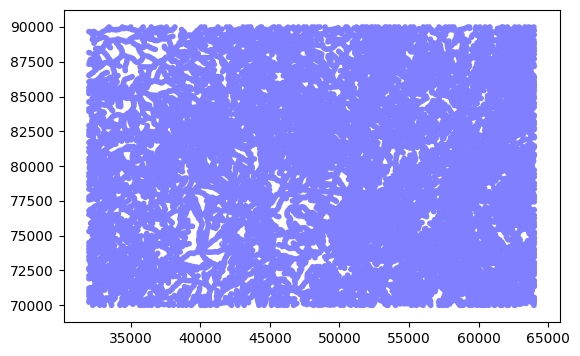

In [38]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt

slopes_path = './Maps_and_GISWEB/fichaexercicios2/f2ex8/declives.tif'
exposure_path = './Maps_and_GISWEB/fichaexercicios2/f2ex8/exposicao.tif'
water_path = './Maps_and_GISWEB/fichaexercicios2/f2ex8/water.shp'

watercourses = gpd.read_file(water_path)
watercourses = watercourses.to_crs(epsg=3763)
buffers = watercourses.copy()
buffers['geometry'] = buffers.geometry.buffer(200)
merged_buffer = buffers.geometry.unary_union
merged_buffer_gdf = gpd.GeoDataFrame(geometry=[merged_buffer])

with rasterio.open(slopes_path) as src:
    data = src.read(1)
    xmin, ymin, xmax, ymax = src.bounds
    
clipped_buffer_gdf = merged_buffer_gdf.cx[xmin:xmax, ymin:ymax]

fig, ax = plt.subplots()
merged_buffer_gdf.plot(ax=ax, facecolor='blue', alpha=0.5)
plt.show()
# ... ???

Exercise  9  |  data  in  f2ex9  |  Generate  a  raster  in which  each  pixel  represents  the  travel  time 
between that cell and the nearest hospital (hospitais.shp), considering a cost surface 
(supcusto.tif). In the supcusto.tif file, the value of each cell indicates the time a person needs 
to travel or cross that pixel area

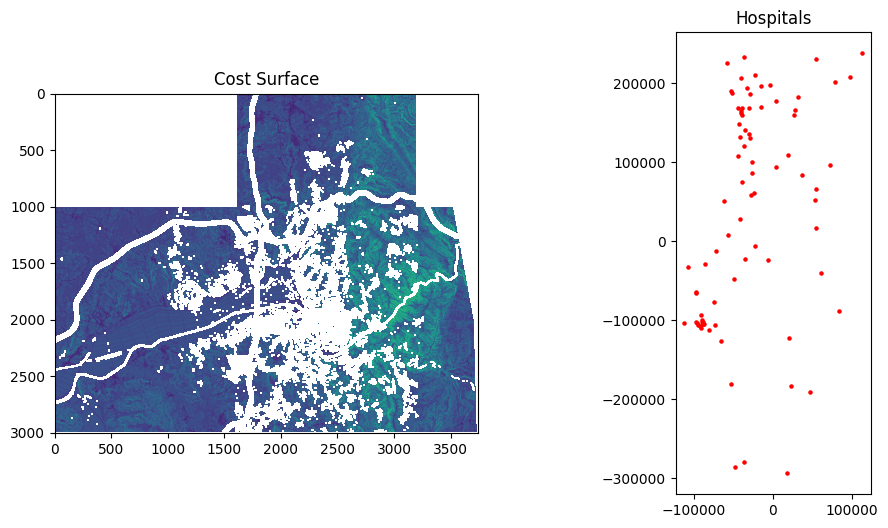

In [21]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt

hospitals_path = "Maps_and_GISWEB/fichaexercicios2/f2ex9/hospitais.shp"
hospitals = gpd.read_file(hospitals_path)

cost_surface_path = "Maps_and_GISWEB/fichaexercicios2/f2ex9/supcusto.tif"
with rasterio.open(cost_surface_path) as cost_surface:
    cost_data = cost_surface.read(1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(cost_data, cmap='viridis')
    ax1.set_title('Cost Surface')

    hospitals.plot(ax=ax2, color='red', markersize=5)
    ax2.set_title('Hospitals')

    plt.show()

### ... ???

In [32]:
# exercise 9
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
from scipy.ndimage import distance_transform_edt
from pyproj import Transformer

hospitals_path = "Maps_and_GISWEB/fichaexercicios2/f2ex9/hospitais.shp"
hospitals = gpd.read_file(hospitals_path)

cost_surface_path = "Maps_and_GISWEB/fichaexercicios2/f2ex9/supcusto.tif"
cost_surface = rasterio.open(cost_surface_path)

cost_data = cost_surface.read(1)

distance_transform = distance_transform_edt(cost_data)

travel_time_raster = np.zeros_like(cost_data, dtype=np.float32)

for idx, hospital in hospitals.iterrows():
    x, y = hospital.geometry.x, hospital.geometry.y
    transformer = Transformer.from_crs(hospitals.crs, cost_surface.crs, always_xy=True)
    x_cost, y_cost = transformer.transform(x, y)

    row, col = cost_surface.index(x_cost, y_cost)

    # Compute the Euclidean distance from the hospital
    distance_to_hospital = distance_transform + np.sqrt((row - x_cost)**2 + (col - y_cost)**2)

    # Update the travel time raster with the calculated distances
    travel_time_raster = np.where(travel_time_raster == 0, distance_to_hospital, np.minimum(travel_time_raster, distance_to_hospital))

with rasterio.open('Maps_and_GISWEB/fichaexercicios2/results/travel_time_raster.tif', 'w', driver='GTiff', width=cost_surface.width, height=cost_surface.height, count=1, dtype=str(travel_time_raster.dtype), crs=cost_surface.crs, transform=cost_surface.transform) as dst:
    dst.write(travel_time_raster, 1)


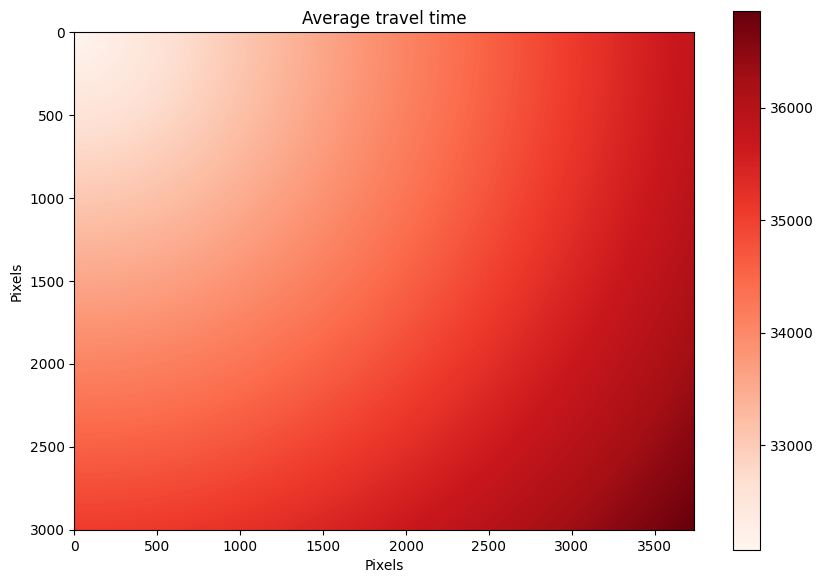

In [35]:
file_path = 'travel_time_raster.tif'
ds = gdal.Open(file_path, gdal.GA_ReadOnly)

band = ds.GetRasterBand(1)
data = band.ReadAsArray().astype(np.float32)

plt.figure(figsize=(10, 7))
plt.imshow(data, cmap='Reds')
plt.colorbar()
plt.title('Average travel time')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

dem_dataset = None